In [1]:
%%capture
# !python3 -V
# Установка зависимостей проекта
%pip install -r requirements.txt

# Установка библиотек для красивых графиков
%pip install matplotlib
%pip install seaborn

import pandas as pd 
import networkx as nx
import itertools
import time
from project.task_9_draft import DynamicSSSP, dijkstra
from project.sssp import bellman_ford
import pygraphblas as pgb
import csv
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
import PIL


Выбираем графы для эксперимента. Графы поделены на 7 групп по количеству вершин: <=100, 1000, 5000, 10000, 25000, 50000, 100000. Генераторы графов социальных сетей (nx.generators.social) порождают графы с числом вершин < 100, поэтому граф социальной сети находится в первой группе. Все остальные графы сгенерированы с помошью (nx.generators.community.random_partition_graph). Функция была выбрана по причине большей понятности в сравнении с её аналогами. В каждой группе по 3 графа. Для групп со 2 по 7 графы состоят из сообществ одинакового размера, число сообществ в графе имеет 3 значения: 1000, 100, 25, что соответсует размеру сообщества 0.1%, 1%, 4% соответственно от общего числа вершин в графе. Таким образом мы анализируем работу алгоритма как при малых, так и при крупных сообществах. В графах есть 2 типа ребер: ребра внутри сообщества и ребра между сообществами. Графы сгенерированы так, чтобы основная часть ребер была ребрами 1-го типа, т.к. это отражает суть того, что связи внутри сообществ тесные, а между различными сообществами - нет.

In [2]:


graphs = {
    # clique_size 0.1%, 1%, 4%

    # <= 100 вершин
    100: [
        nx.DiGraph(nx.generators.social.les_miserables_graph()),
        nx.generators.community.random_partition_graph([1]*100, 1, 0.04, directed=True),
        nx.generators.community.random_partition_graph([4]*25, 1, 0.04, directed=True),
    ],

    # 1000 вершин
    1000: [
        nx.generators.community.random_partition_graph([1]*1000, 1, 0.0025, directed=True),
        nx.generators.community.random_partition_graph([10]*100, 0.45, 0.0025, directed=True),
        nx.generators.community.random_partition_graph([40]*25, 0.2, 0.0025, directed=True),
    ],

    # 5000 вершин
    5000: [
        nx.generators.community.random_partition_graph([5]*1000, 0.45, 0.0004, directed=True),
        nx.generators.community.random_partition_graph([50]*100, 0.075, 0.0004, directed=True),
        nx.generators.community.random_partition_graph([200]*25, 0.025, 0.0004, directed=True),
    ],
    
    # 10_000 вершин
    10_000: [
        nx.generators.community.random_partition_graph([10]*1000, 0.35, 0.0002, directed=True),
        nx.generators.community.random_partition_graph([100]*100, 0.05, 0.0002, directed=True),
        nx.generators.community.random_partition_graph([400]*25,  0.015, 0.0002, directed=True),
    ],
    
    # 25_000 вершин
    25_000: [
        nx.generators.community.random_partition_graph([25]*1000, 0.1, 0.00005, directed=True),
        nx.generators.community.random_partition_graph([250]*100, 0.025, 0.00005, directed=True),
        nx.generators.community.random_partition_graph([1000]*25, 0.005, 0.00005, directed=True),
    ],

    # 50_000 вершин
    50_000: [
        nx.generators.community.random_partition_graph([50]*1000, 0.05, 0.000025, directed=True),
        nx.generators.community.random_partition_graph([500]*100, 0.01, 0.000025, directed=True),
        nx.generators.community.random_partition_graph([2000]*25, 0.003, 0.000025, directed=True),
    ],
    
    # 100_000 вершин
    100_000: [
        nx.generators.community.random_partition_graph([100]*1000, 0.05, 0.0000125, directed=True),
        nx.generators.community.random_partition_graph([1000]*100, 0.005, 0.0000125, directed=True),
        nx.generators.community.random_partition_graph([4000]*25,  0.001, 0.0000125, directed=True),
    ]
}

def iter_graphs():
    return itertools.chain(*graphs.values())

for g in iter_graphs():
    print(g)




DiGraph with 77 nodes and 508 edges
DiGraph named 'stochastic_block_model' with 100 nodes and 345 edges
DiGraph named 'stochastic_block_model' with 100 nodes and 674 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 2420 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 6592 edges
DiGraph named 'stochastic_block_model' with 1000 nodes and 10342 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 19102 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 28249 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 34381 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 51534 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 69248 edges
DiGraph named 'stochastic_block_model' with 10000 nodes and 79228 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 90980 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 186767 edges
DiGraph named 'stochastic_block_model' with

Код для выполнения замеров. Заметим, что время на подготовительную работу не входит в замер. Подготовительная работа это:
1) Инициализации динамического алгоритма на еще неизмененном графе. Поскольку инициализация производится лишь единожды, а нас же интересует перерасчет расстояний при изменении графа
2) Изменение ребер графа т.е. их удалении и добавление. Поскольку мы все изменения обрабатываем одной пачкой
3) Создание на основе графа матрицы смежности для алгоритма Белмана-Форда. Когда матричный алгоритм Белмана-Форда используется на практике, то граф будет изначально хранится в виде матрицы и поэтому в такой процедуре не будет надобности.

In [2]:
def select_edges(g: nx.DiGraph, edges_part: float):
    n = int(g.number_of_edges() * edges_part)
    return random.sample(list(g.edges), k=n)


def measure_dynamic_dijkstra(graph: nx.DiGraph, type='incremental', add_edges=[], del_edges=[]):
    if type == 'incremental':
        modifiable_graph = nx.DiGraph()
        modifiable_graph.add_nodes_from(graph.nodes)
        
        start_vertex = list(modifiable_graph)[0]
        dynamic_sssp = DynamicSSSP(modifiable_graph, start_vertex)
        
        for e in add_edges:
            dynamic_sssp.add_edge(*e)

        start_time = time.time()
        dynamic_sssp.get_distances()
        end_time = time.time()

        return end_time - start_time
    
    if type == 'decremental':
        modifiable_graph = nx.DiGraph(graph)
        start_vertex = list(modifiable_graph)[0]
        dynamic_sssp = DynamicSSSP(modifiable_graph, start_vertex)
        
        for e in del_edges:
            dynamic_sssp.remove_edge(*e)

        start_time = time.time()
        dynamic_sssp.get_distances()
        end_time = time.time()

        return end_time - start_time

    if type == 'full':
        modifiable_graph = nx.DiGraph(graph)

        start_vertex = list(modifiable_graph)[0]
        dynamic_sssp = DynamicSSSP(modifiable_graph, start_vertex)

        for e_add, e_del in itertools.zip_longest(add_edges, del_edges):
            if e_add:
                dynamic_sssp.add_edge(*e_add)
            if e_del:
                dynamic_sssp.remove_edge(*e_del)

        start_time = time.time()
        dynamic_sssp.get_distances()
        end_time = time.time()

        return end_time - start_time
    
    raise Exception('type must be from [\'incremental', 'decremental', 'full\']')


def measure_static_dijkstra(graph: nx.DiGraph, type='incremental', add_edges=[], del_edges=[]):
    if type == 'incremental':
        modifiable_graph = nx.DiGraph()
        modifiable_graph.add_nodes_from(graph.nodes)
        start_vertex = list(modifiable_graph)[0]

        for e in add_edges:
            modifiable_graph.add_edge(*e)

        start_time = time.time()
        dijkstra(modifiable_graph, start_vertex)
        end_time = time.time()
    
        return end_time - start_time
        
    if type == 'decremental':
        modifiable_graph = nx.DiGraph(graph)
        start_vertex = list(modifiable_graph)[0]
        
        for e in del_edges:
            modifiable_graph.remove_edge(*e)

        start_time = time.time()
        dijkstra(modifiable_graph, start_vertex)
        end_time = time.time()

        return end_time - start_time

    if type == 'full':
        modifiable_graph = nx.DiGraph(graph)
        start_vertex = list(modifiable_graph)[0]
        
        for e_add, e_del in itertools.zip_longest(add_edges, del_edges):
            if e_add:
                modifiable_graph.add_edge(*e_add)
            if e_del:
                modifiable_graph.remove_edge(*e_del)

        start_time = time.time()
        dijkstra(modifiable_graph, start_vertex)
        end_time = time.time()

        return end_time - start_time


def measure_bellman_ford(graph: nx.DiGraph, type='incremental', add_edges=[], del_edges=[]):
    if type == 'incremental':
        modifiable_graph = nx.DiGraph()
        modifiable_graph.add_nodes_from(graph.nodes)

        for e in add_edges:
            modifiable_graph.add_edge(*e)

        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.adjacency_matrix(modifiable_graph))

        start_time = time.time()
        bellman_ford(adj_matrix, 0)
        end_time = time.time()
    
        return end_time - start_time
        
    if type == 'decremental':
        modifiable_graph = nx.DiGraph(graph)
    
        for e in del_edges:
            modifiable_graph.remove_edge(*e)

        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.adjacency_matrix(modifiable_graph))
            
        start_time = time.time()
        bellman_ford(adj_matrix, 0)
        end_time = time.time()
        
        return end_time - start_time

    if type == 'full':
        modifiable_graph = nx.DiGraph(graph)

        for e_add, e_del in itertools.zip_longest(add_edges, del_edges):
            if e_add:
                modifiable_graph.add_edge(*e_add)
            if e_del:
                modifiable_graph.remove_edge(*e_del)
                
        adj_matrix = pgb.Matrix.from_scipy_sparse(nx.adjacency_matrix(modifiable_graph))

        start_time = time.time()
        # нужен не start_vertex, а лишь индекс
        bellman_ford(adj_matrix, 0)
        end_time = time.time()
        
        return end_time - start_time

Производим замеры 


In [4]:
with open('results.csv', 'w',) as csvfile:
    writer = csv.writer(csvfile)

    for test_var in [
        'incremental', 
        'decremental', 
        'full'
    ]:
        for edges_part in [0.1, 0.2, 0.3, 0.4, 0.5]:
            for nodes_num, graph_list in graphs.items():
                for g in graph_list:
                    add_edges=[]
                    del_edges=[]
                    if test_var == 'incremental':
                        add_edges = select_edges(g, edges_part)
                    if test_var == 'decremental':
                        del_edges = select_edges(g, edges_part)
                    if test_var == 'full':
                        edges = select_edges(g, edges_part)
                        add_edges_num = len(edges) // 2
                        del_edges_num = len(edges) - add_edges_num

                        add_edges = random.sample(edges, k=add_edges_num)
                        g = nx.DiGraph(g)
                        g.remove_edges_from(add_edges)
                        del_edges = random.sample(list(g.edges), k=del_edges_num)

                    t = measure_dynamic_dijkstra(nx.DiGraph(g), test_var, add_edges, del_edges)
                    writer.writerow((test_var, edges_part, 'dynamic', nodes_num, t))
                    print(test_var, edges_part, 'dynamic', nodes_num, t)

                    t = measure_static_dijkstra(nx.DiGraph(g), test_var, add_edges, del_edges)
                    writer.writerow((test_var, edges_part, 'dijkstra', nodes_num, t))
                    print(test_var, edges_part, 'dijkstra', nodes_num, t)

                    t = measure_bellman_ford(nx.DiGraph(g), test_var, add_edges, del_edges)
                    writer.writerow((test_var, edges_part, 'matrix', nodes_num, t))
                    print(test_var, edges_part, 'matrix', nodes_num, t)
                    

incremental 0.1 dynamic 100 6.985664367675781e-05
incremental 0.1 dijkstra 100 2.0503997802734375e-05
incremental 0.1 matrix 100 0.0014405250549316406
incremental 0.1 dynamic 100 8.869171142578125e-05
incremental 0.1 dijkstra 100 3.361701965332031e-05
incremental 0.1 matrix 100 0.0024793148040771484
incremental 0.1 dynamic 100 0.0007312297821044922
incremental 0.1 dijkstra 100 4.2438507080078125e-05
incremental 0.1 matrix 100 0.0016651153564453125
incremental 0.1 dynamic 1000 0.0004584789276123047
incremental 0.1 dijkstra 1000 0.0003082752227783203
incremental 0.1 matrix 1000 0.01614212989807129
incremental 0.1 dynamic 1000 0.0010814666748046875
incremental 0.1 dijkstra 1000 0.00014400482177734375
incremental 0.1 matrix 1000 0.008821725845336914
incremental 0.1 dynamic 1000 0.0018987655639648438
incremental 0.1 dijkstra 1000 0.00017380714416503906
incremental 0.1 matrix 1000 0.008886098861694336
incremental 0.1 dynamic 5000 0.0018436908721923828
incremental 0.1 dijkstra 5000 0.00072503

Сохраняем все замеры в виде таблицы, чтобы потом было удобно визуализировать результаты

In [1]:
df = pd.read_csv('results.csv', names=['test_variant', 'modified_edges_part', 'algo', 'nodes', 'time(s)'])
df

,test_variant,modified_edges_part,algo,nodes,time(s)
0,incremental,0.1,dynamic,100,0.000070
1,incremental,0.1,dijkstra,100,0.000021
2,incremental,0.1,matrix,100,0.001441
3,incremental,0.1,dynamic,100,0.000089
4,incremental,0.1,dijkstra,100,0.000034
...,...,...,...,...,...
940,full,0.5,dijkstra,100000,0.349730
941,full,0.5,matrix,100000,692.794231
942,full,0.5,dynamic,100000,2.872588
943,full,0.5,dijkstra,100000,0.352174


Визуализируем результаты

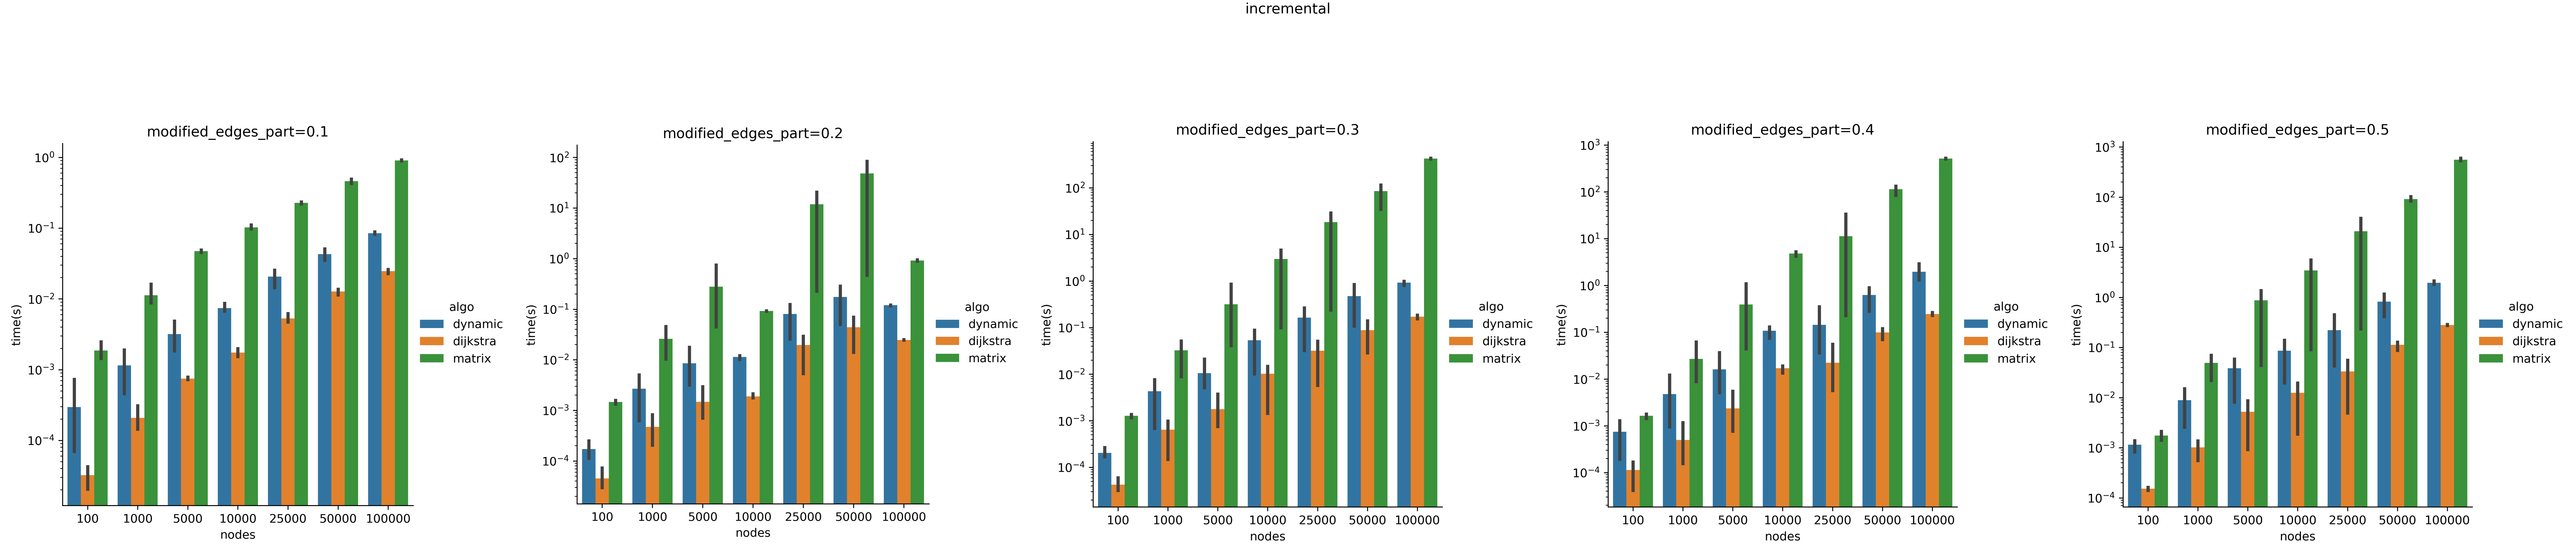

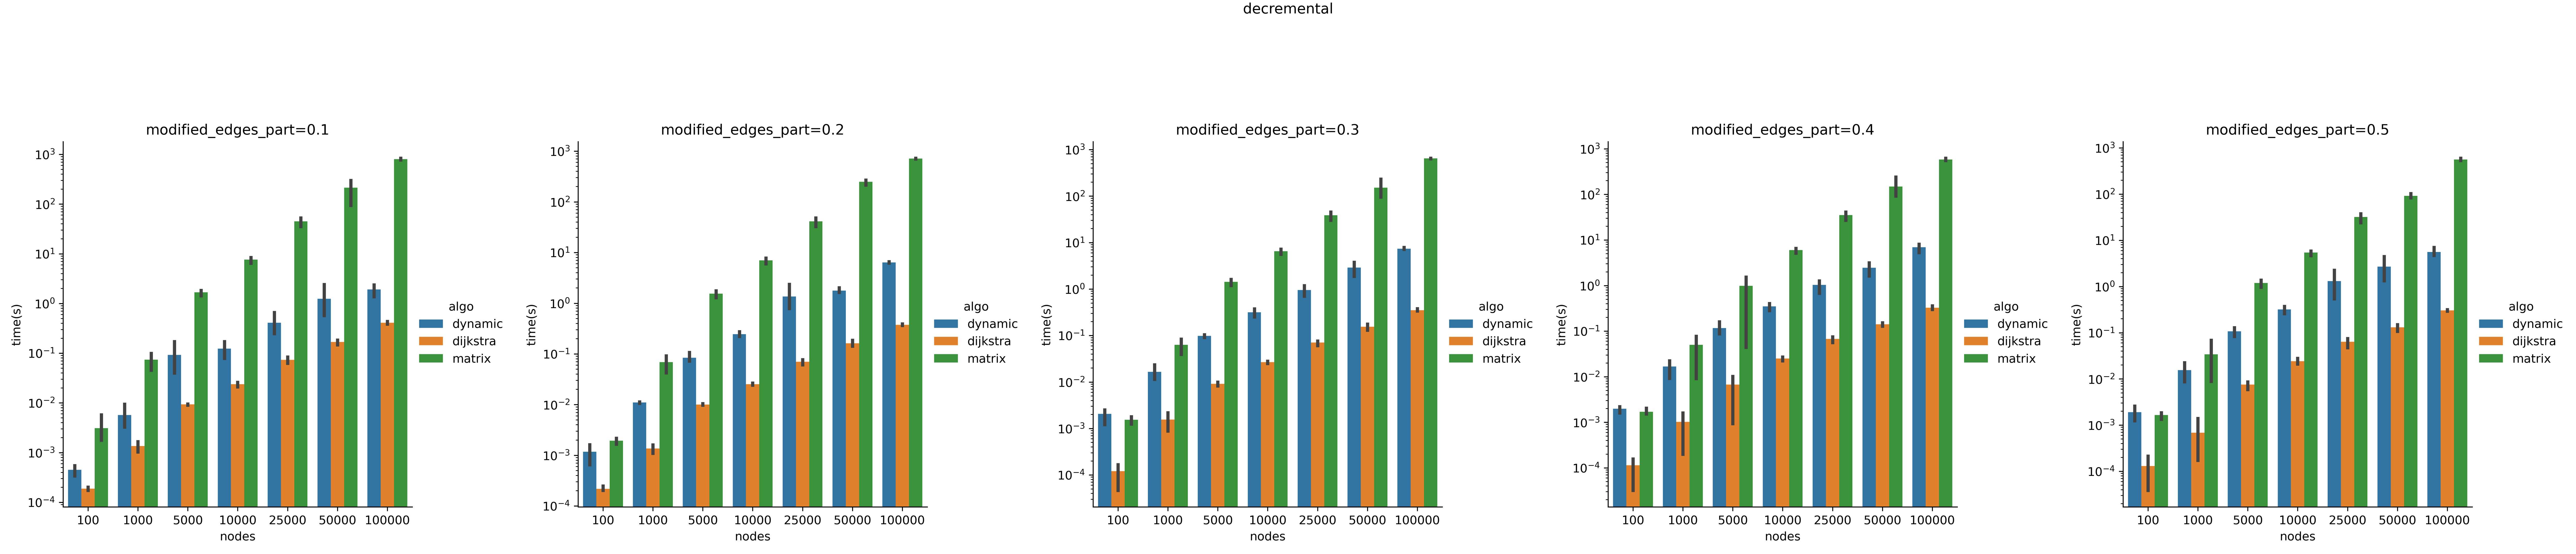

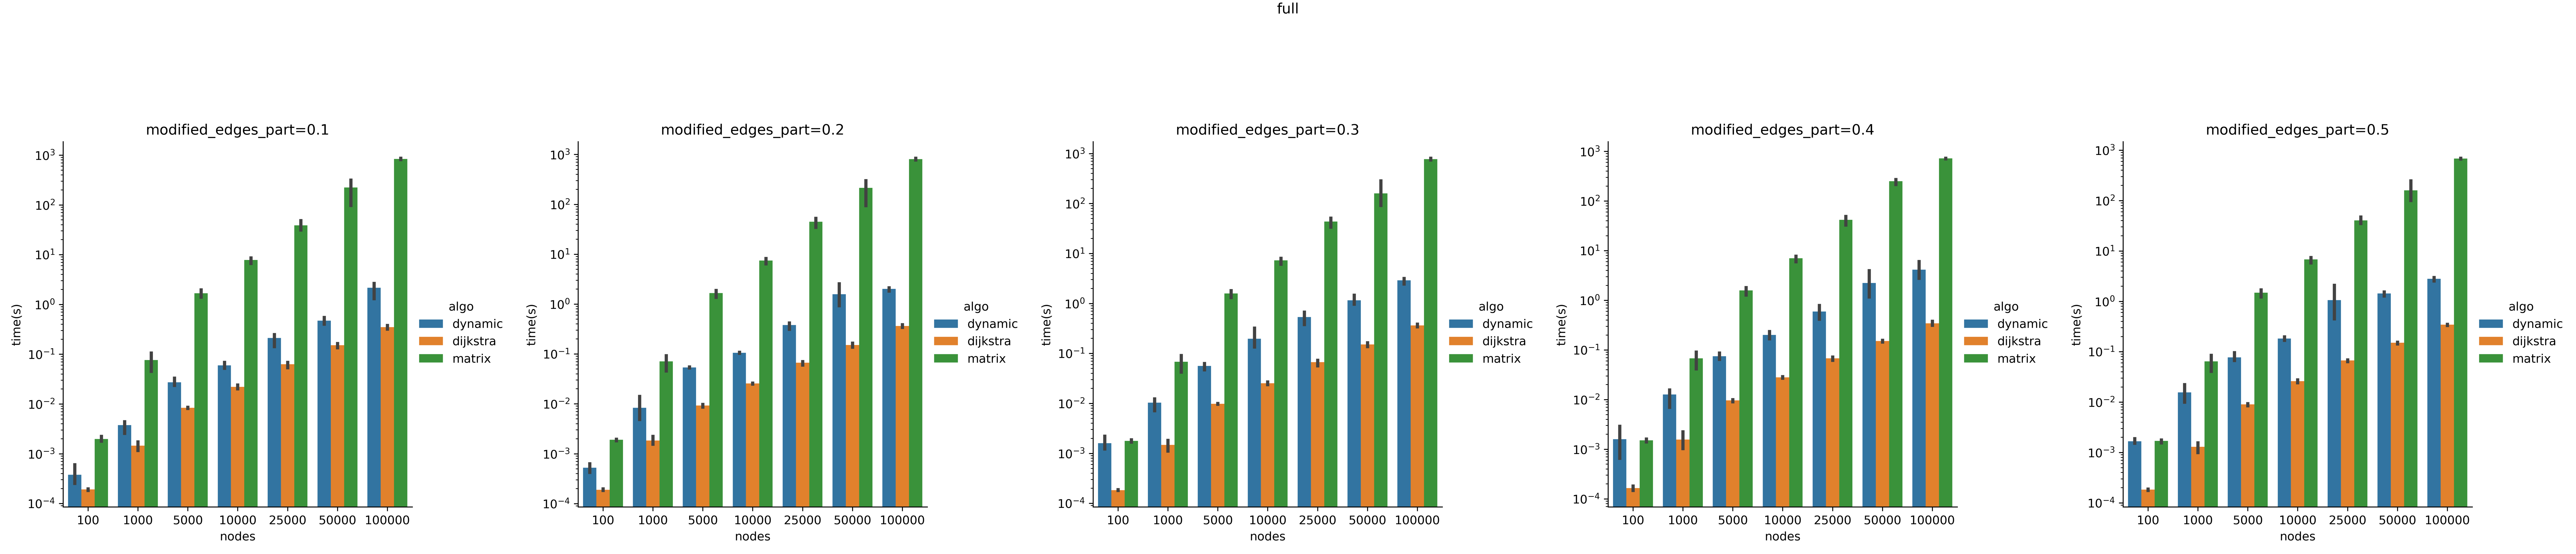

In [2]:
def to_image(plot):
    buffer = io.BytesIO()
    plot.figure.savefig(buffer, format="png", bbox_inches="tight", dpi=450)
    return PIL.Image.open(buffer)


for test_variant in [
    'incremental', 
    'decremental', 
    'full'
]:
    plots = []
    for mod_edge_part in [0.1, 0.2, 0.3, 0.4, 0.5]:
        filtered_df = df[
            np.logical_and(df['test_variant'] == test_variant, df['modified_edges_part'] == mod_edge_part)
        ]
        plot = sns.catplot(
            data=filtered_df, 
            x="nodes",
            y="time(s)",
            hue="algo",
            kind='bar', 
        )
        plt.title(f"modified_edges_part={mod_edge_part}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()
    
    fig, axs = plt.subplots(ncols=5, figsize=(100, 50))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"{test_variant}", y=0.75, size=40)


Итоги:
1) Самая плохая производительность у матричного алгоритма Белмана-Форда, при этом отставание от алгоритмов Дейкстры увеличивается с ростом размера графа. Плохую производительность матричного алгоритма можно объяснить тем, что она зависит во первых от числа вершин в графе т.к. это определяет размер матрицы и кол-во матричных умножений, которое будет выполенно алгоритмом в любом случае, поскольку в реализации не отслеживается изменилась ли матрица в сравнении с предыдущим шагом или нет. Также в более крупных графах было больше ребер и соответственно в матрице смежности будет больше ненулевых элементов, что также повысит время выполнения одной операции матричного умножения
2) При доле модифицированных ребер от 10% до 50% от общего числа ребер в графе динамический алгоритм Дейкстры работает медленнее статического во всех 3х вариантах эксперимента [Как-то грустно]

## Итог 2 меня смущает

До проведения эксперимента я ожидал, что при малой доле измененных ребер динамический алгоритм проявит себя лучше. По этой причине сейчас я отойду от условия задачи и проведу замеры при более низкой доле изменных ребер в надежде установить при каких условиях динамический алгоритм оправдает себя и покажает лучшую производительность.

На этом этапе матричный алгоритм будет исключен из рассмотрения т.к. про него уже выяснили, что работает он сильно медленнее 2х других алгоритмов.

Также используем графы только 3х размеров: 5000, 25000 и 100000 вершин. В каждом графе будет 2% ребер соединяющих сообщества, остальные 98% ребер это ребра между вершинами одного сообщества. Каждый граф состоит из 100 сообществ равного размера.

In [3]:
# out_edges_part = 2%
# clique_size = 1%

graphs = {
    5_000: [
        nx.generators.community.random_partition_graph([50]*100, 0.12, 0.000025, directed=True),
        nx.generators.community.random_partition_graph([50]*100, 0.32, 0.000065, directed=True),
    ],

    25_000: [
        nx.generators.community.random_partition_graph([250]*100, 0.02, 0.000004, directed=True),
        nx.generators.community.random_partition_graph([250]*100, 0.063, 0.000013, directed=True),
    ],

    100_000: [
        nx.generators.community.random_partition_graph([1000]*100, 0.00588, 0.0000012, directed=True),
        nx.generators.community.random_partition_graph([1000]*100, 0.01568, 0.0000032, directed=True),
    ],
}

for g in itertools.chain(*graphs.values()):
    print(g)

DiGraph named 'stochastic_block_model' with 5000 nodes and 29923 edges
DiGraph named 'stochastic_block_model' with 5000 nodes and 80005 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 127159 edges
DiGraph named 'stochastic_block_model' with 25000 nodes and 400350 edges
DiGraph named 'stochastic_block_model' with 100000 nodes and 599188 edges
DiGraph named 'stochastic_block_model' with 100000 nodes and 1597049 edges


In [4]:
with open('bonus_6_16.csv', 'w',) as csvfile:
    writer = csv.writer(csvfile)

    for test_var in [
        'incremental', 
        'decremental', 
        'full'
    ]:
        for edges_part in [1e-3, 5e-3, 1e-2, 3e-2]:
            for nodes_num, graph_list in graphs.items():
                for g in graph_list:
                    g2 = nx.DiGraph(g)
                    add_edges=[]
                    del_edges=[]
                    if test_var == 'incremental':
                        add_edges = select_edges(g, edges_part)
                    if test_var == 'decremental':
                        del_edges = select_edges(g, edges_part)
                    if test_var == 'full':
                        edges = select_edges(g, edges_part)
                        add_edges_num = len(edges) // 2
                        del_edges_num = len(edges) - add_edges_num

                        add_edges = random.sample(edges, k=add_edges_num)
                        g2.remove_edges_from(add_edges)
                        del_edges = random.sample(list(g2.edges), k=del_edges_num)

                    t = measure_dynamic_dijkstra(g2, test_var, add_edges, del_edges)
                    info = (
                        test_var,
                        'dynamic',
                        nodes_num, 
                        g.number_of_edges(), 
                        edges_part,
                        len(add_edges) + len(del_edges),
                        t
                    )
                    writer.writerow(info)
                    print(info)

                    t = measure_static_dijkstra(g2, test_var, add_edges, del_edges)
                    info = (
                        test_var,
                        'static',
                        nodes_num, 
                        g.number_of_edges(), 
                        edges_part,
                        len(add_edges) + len(del_edges),
                        t
                    )
                    writer.writerow(info)
                    print(info)

('incremental', 'dynamic', 5000, 29923, 0.001, 29, 6.532669067382812e-05)
('incremental', 'static', 5000, 29923, 0.001, 29, 0.0007777214050292969)
('incremental', 'dynamic', 5000, 80005, 0.001, 80, 0.00011420249938964844)
('incremental', 'static', 5000, 80005, 0.001, 80, 0.0006785392761230469)
('incremental', 'dynamic', 25000, 127159, 0.001, 127, 0.0001919269561767578)
('incremental', 'static', 25000, 127159, 0.001, 127, 0.003676891326904297)
('incremental', 'dynamic', 25000, 400350, 0.001, 400, 0.0006480216979980469)
('incremental', 'static', 25000, 400350, 0.001, 400, 0.003561258316040039)
('incremental', 'dynamic', 100000, 599188, 0.001, 599, 0.0016069412231445312)
('incremental', 'static', 100000, 599188, 0.001, 599, 0.015921592712402344)
('incremental', 'dynamic', 100000, 1597049, 0.001, 1597, 0.002571582794189453)
('incremental', 'static', 100000, 1597049, 0.001, 1597, 0.014984130859375)
('incremental', 'dynamic', 5000, 29923, 0.005, 149, 0.000240325927734375)
('incremental', 'st

In [2]:
df = pd.read_csv('bonus_6_16.csv', names=['mode', 'algo', 'g_nodes', 'g_edges', 'edges_part', 'modified_edges', 'time(s)'])
df

,mode,algo,g_nodes,g_edges,edges_part,modified_edges,time(s)
0,incremental,dynamic,5000,29923,0.001,29,0.000065
1,incremental,static,5000,29923,0.001,29,0.000778
2,incremental,dynamic,5000,80005,0.001,80,0.000114
3,incremental,static,5000,80005,0.001,80,0.000679
4,incremental,dynamic,25000,127159,0.001,127,0.000192
...,...,...,...,...,...,...,...
139,full,static,25000,400350,0.030,12010,0.083189
140,full,dynamic,100000,599188,0.030,17975,0.420705
141,full,static,100000,599188,0.030,17975,0.337347
142,full,dynamic,100000,1597049,0.030,47911,0.789095


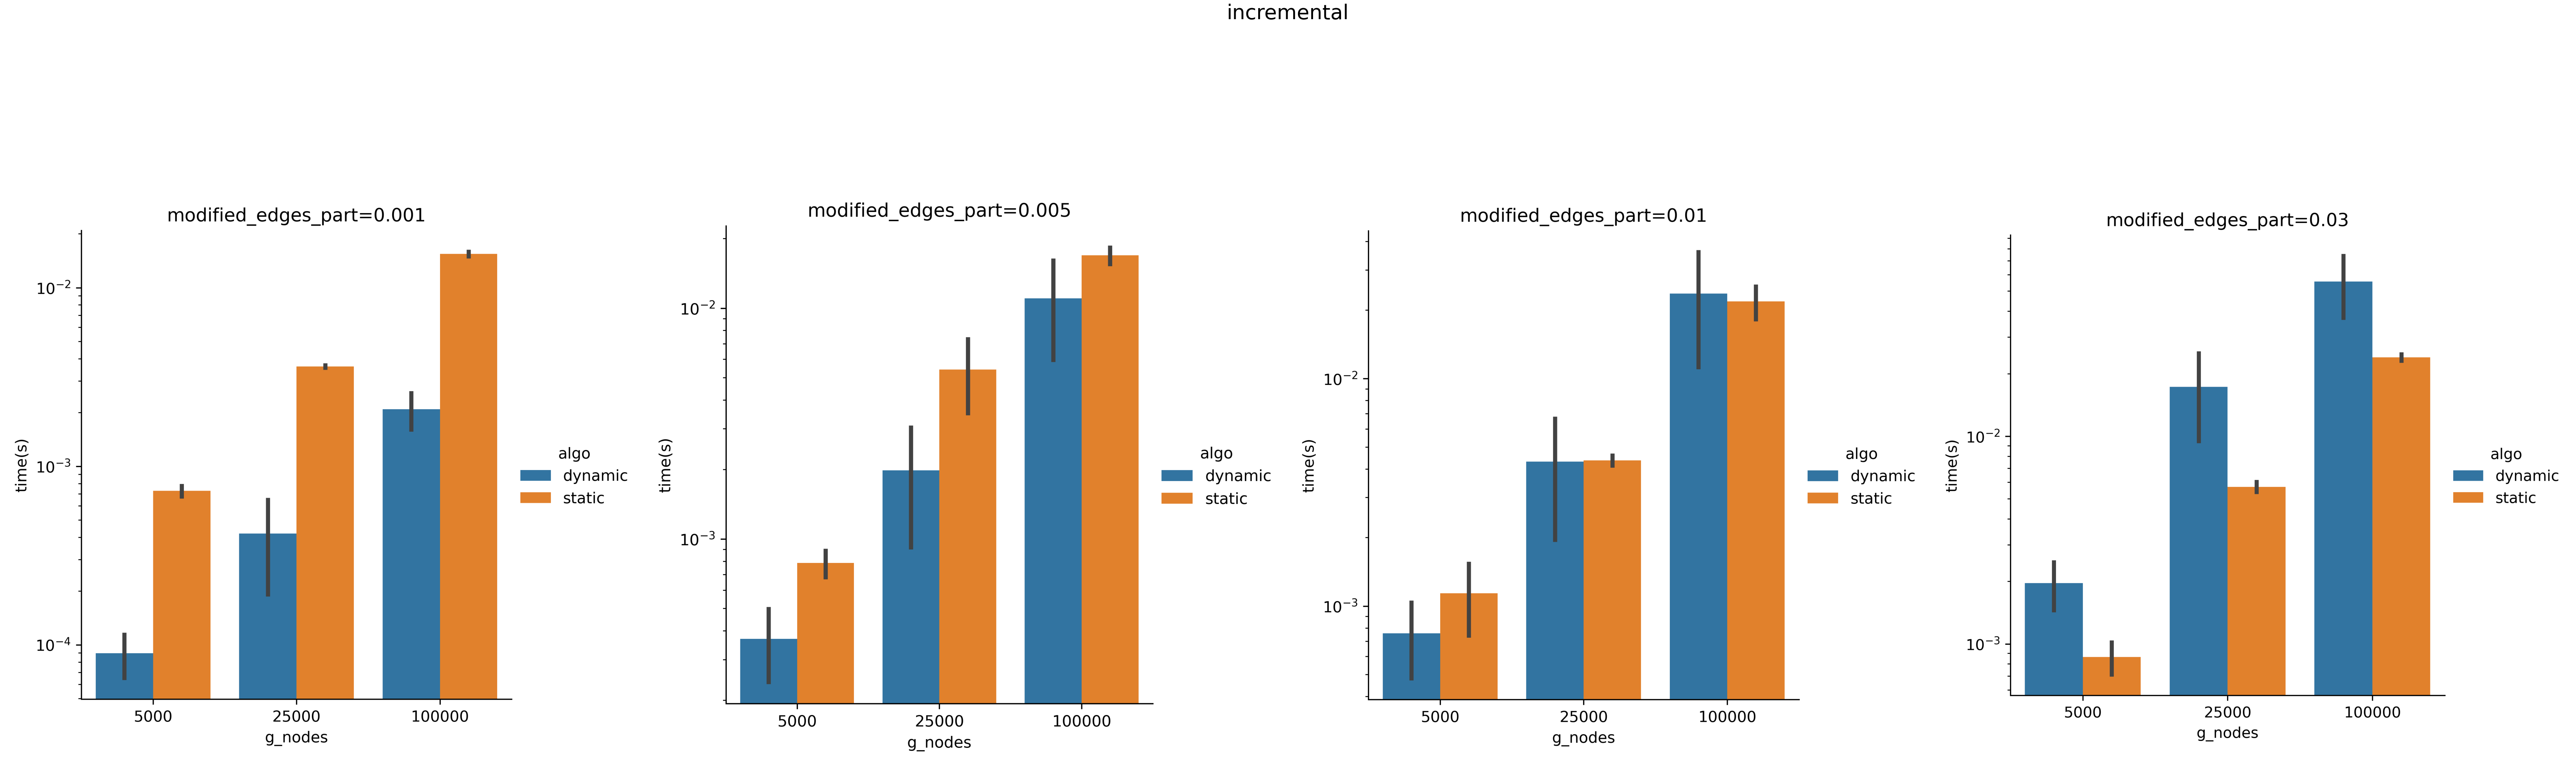

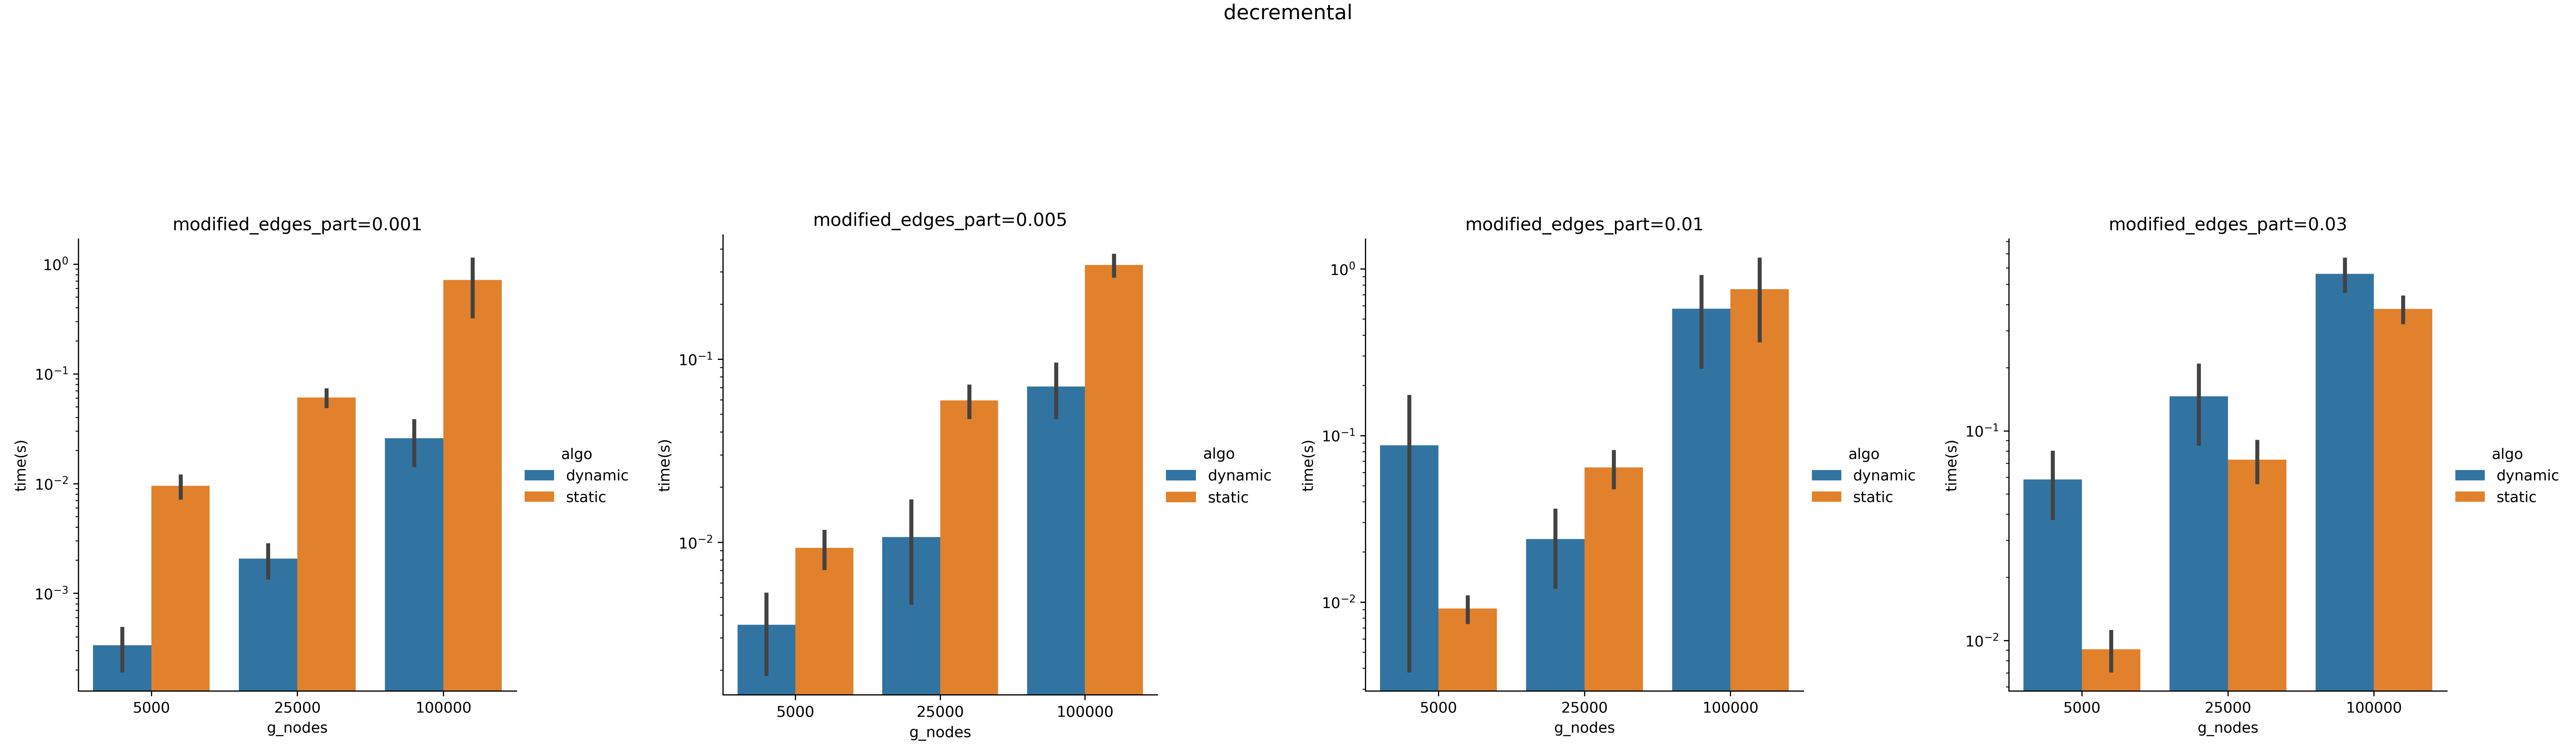

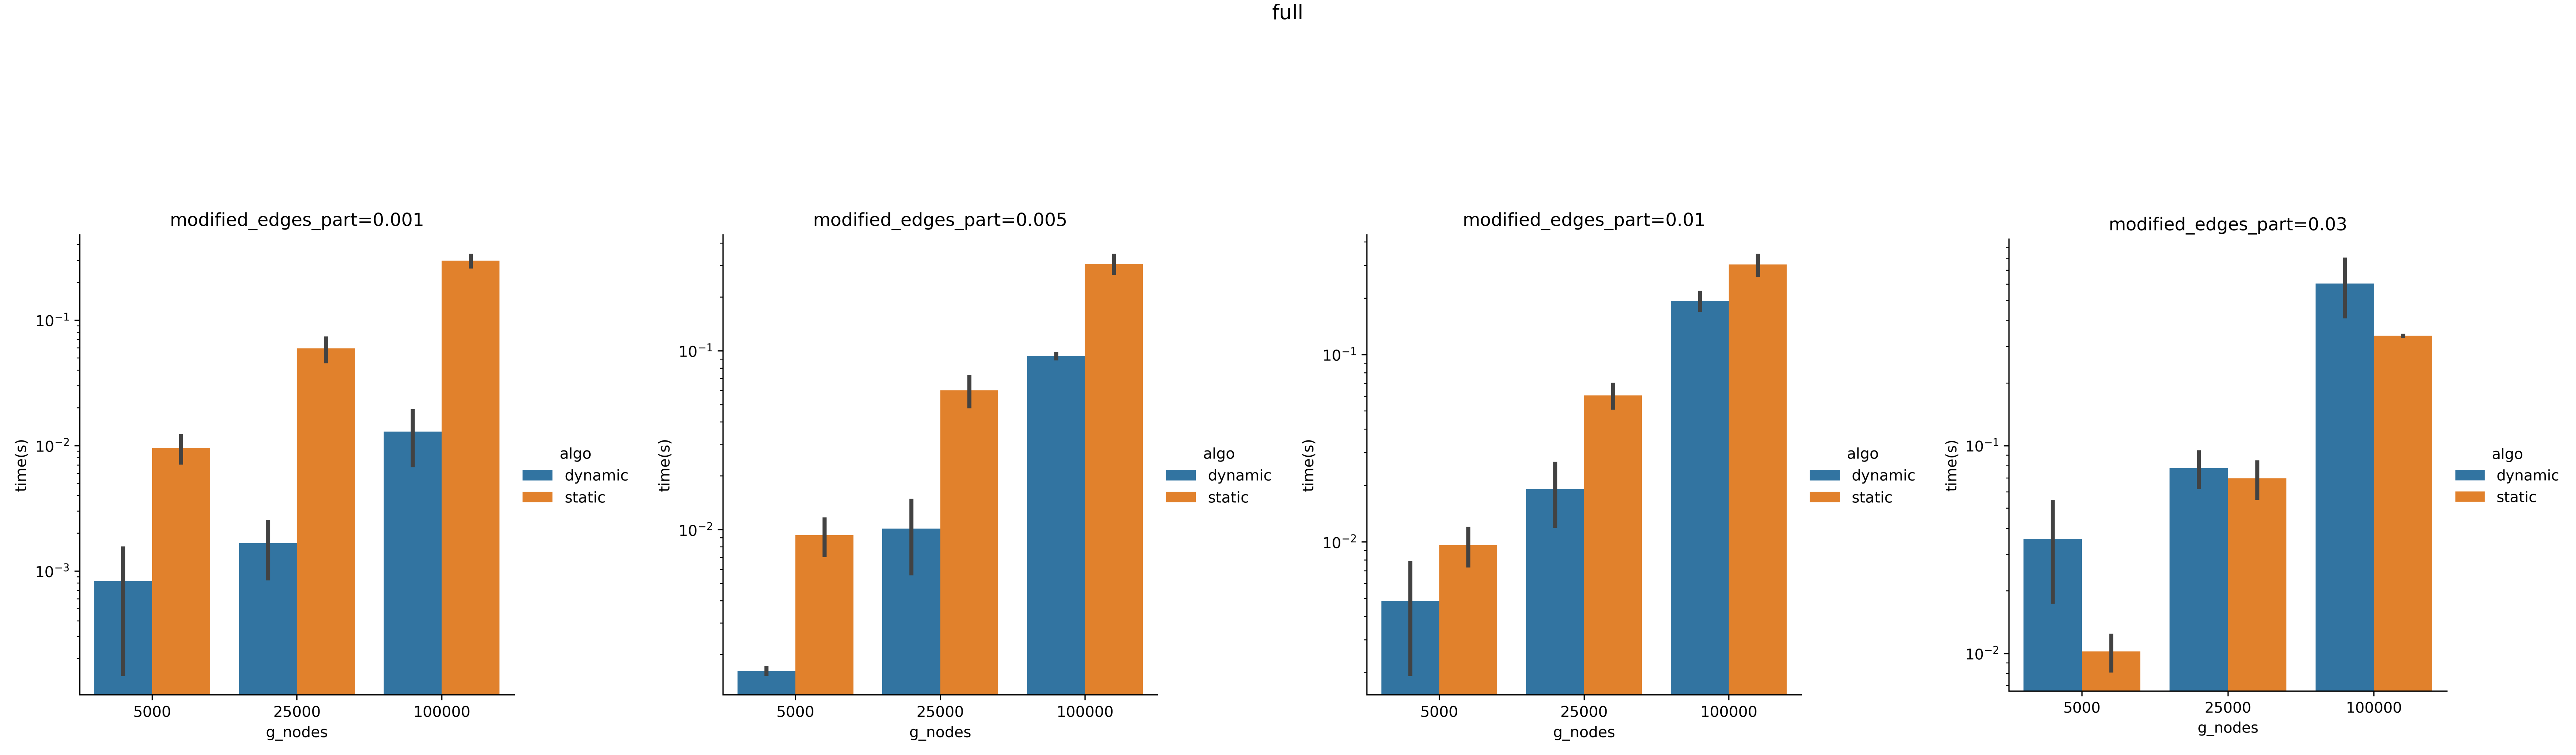

In [8]:
def to_image(plot):
    buffer = io.BytesIO()
    plot.figure.savefig(buffer, format="png", bbox_inches="tight", dpi=450)
    return PIL.Image.open(buffer)

for mode in [
    'incremental', 
    'decremental', 
    'full'
]:
    plots = []
    for edges_part in [1e-3, 5e-3, 1e-2, 3e-2]:
        filtered_df = df[
            np.logical_and(df['mode'] == mode, df['edges_part'] == edges_part)
        ]
        plot = sns.catplot(
            data=filtered_df, 
            x="g_nodes",
            y="time(s)",
            hue="algo",
            kind='bar', 
        )
        plt.title(f"modified_edges_part={edges_part}")
        plt.yscale("log")
        plots.append(to_image(plot))
        plt.close()
    
    fig, axs = plt.subplots(ncols=4, figsize=(70, 50))
    for ax, plot in zip(axs, plots):
        ax.imshow(plot)
        ax.axis("off")
    fig.set_tight_layout(True)
    fig.suptitle(f"{mode}", y=0.75, size=40)




Вывод:
1) Проведенный эксперимент показал, что динамический алгоритм показывает сопоставимое или лучшее время работы, если число изменившихся ребер не превосходит 1% от их общего числа, независимо от варианта проведения эксперимента (инкрементальный, декрементальный, смешанный)
2) Таким образом, если в графе изменилось <= 1% ребер, то рекомендуется использовать динамический алгоритм, в остальных случаях лучше будет воспользоваться статическим алгоритмом